In [18]:
import pandas as pd
from scipy.io import loadmat, savemat
import numpy as np
import pyvista
import pyvista as pv
import numpy as np
import vtk
from scipy.spatial.transform import Rotation
from PCA_model import PCA_model, registration_to_strocchi, save_points_to_vtk


In [21]:
# input files in shared folder
# caeser data (humanshape model) from Internet
path_to_meanshape_file = r'D:\xuhu\humanshape\PCA_model_registration\input\meanShape.mat'
path_to_evectors = r'D:\xuhu\humanshape\PCA_model_registration\input\evectors.mat'
path_to_evalues = r'D:\xuhu\humanshape\PCA_model_registration\input\evalues.mat'


# file use for extract torso part from meanshape
torso_csv_file_path = r"D:\xuhu\humanshape\PCA_model_registration\input\Torso.csv"
torso_mat_file_path = r'D:\xuhu\pyansys-heart\examples\PCA\New_torso.mat'
torso_evectors_mat_file_path = r'D:\xuhu\pyansys-heart\examples\PCA\Torso_evectors.mat'

PCA_predefined_anatomical_points_path = r"D:\xuhu\humanshape\PCA_model_registration\input\PCA_define_ap.csv"

In [22]:
pca_torso_model = PCA_model()
pca_torso_model.initialize_PCA_model(torso_mat_file_path, path_to_evalues, torso_evectors_mat_file_path)

In [23]:
# define pca anatomical points
pca_ap = pd.read_csv(PCA_predefined_anatomical_points_path)
ap_points_array = pca_ap[['Points_0', 'Points_1', 'Points_2']].to_numpy()
pca_torso_model.anatomical_points = ap_points_array

c:\ProgramData\miniforge3\envs\env39\lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


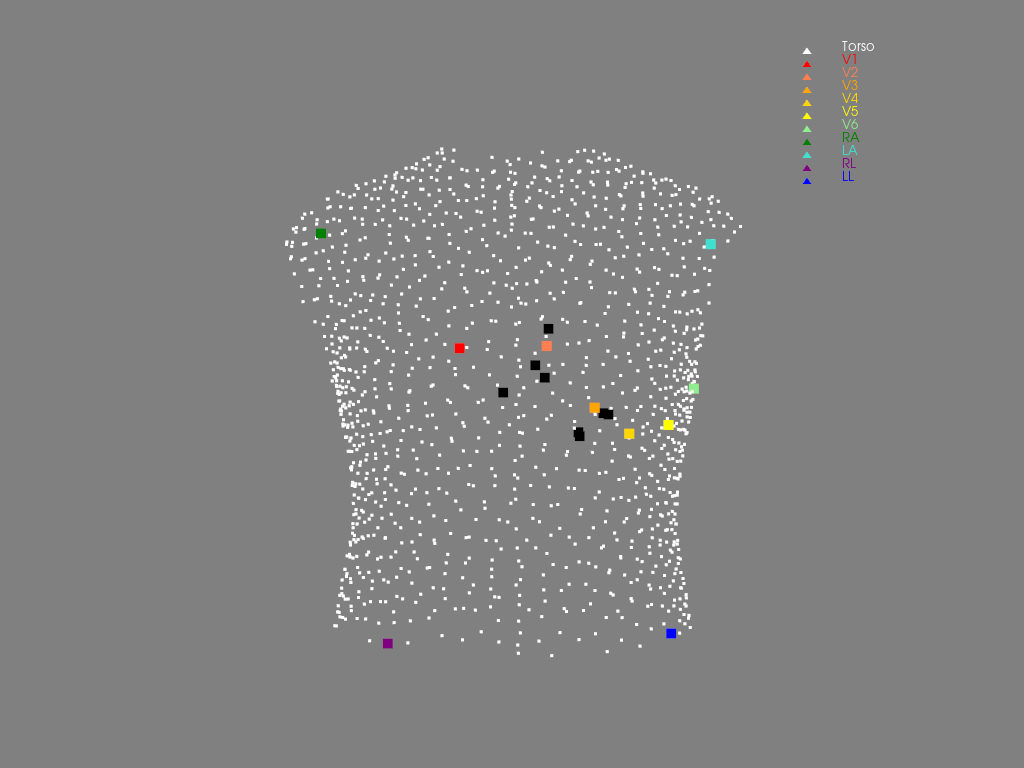

In [27]:
# show pca model
body_points = np.array(list(pca_torso_model.body.values()))
body_polydata = pyvista.PolyData(body_points)

anatomical_point_polydata = pyvista.PolyData(np.array(pca_torso_model.anatomical_points))


plotter = pyvista.Plotter()

# plotter.add_mesh(anatomical_point_polydata, color='green', point_size=10)
plotter.add_mesh(body_polydata, color='white', label='Torso', point_size=3)

electrode_colors = {
    "V1": 'red',
    "V2": 'coral',
    "V3": 'orange',
    "V4": 'gold',
    "V5": 'yellow',
    "V6": 'lightgreen',
    "RA": 'green',
    "LA": 'turquoise',
    "LL": 'blue',
    "RL": 'purple',
}

for name, index in pca_torso_model.electrodes.items():
    electrode_point = np.array(pca_torso_model.body[index])
    electrode_polydata = pv.PolyData(electrode_point)
    color = electrode_colors.get(name, 'grey')
    plotter.add_mesh(electrode_polydata, color=color, point_size=10, label=name)

# plotter.add_mesh(model.mesh, color="blue", opacity=0.3)
plotter.add_mesh(pca_torso_model.anatomical_points, color="black", point_size=10)

# plotter.add_legend()
    
plotter.add_legend()
plotter.camera_position = 'xz'
plotter.background_color = 'grey'

plotter.show()

# PCA torso deformation

In [8]:
# PCA deformation
'''
Sigma range:
Mode ID = 1 \ Sigma: -+0.00075
Mode ID = 2 \ Sigma: -+0.0008
Mode ID = 3 \ Sigma: -+0.001
'''
mode_id=1
sigma=0.00075
deformed_pca_save_file = f'D:\\xuhu\\humanshape\\PCA_model_registration\\output\\mode_{mode_id}_sigma_{sigma}.vtk'
path_to_evectors = r'D:\xuhu\humanshape\PCA_model_registration\input\Torso_evectors.mat'
pca_torso_model.deformation(mode_id=mode_id, sigma=sigma, save=False, filename=deformed_pca_save_file, path_to_evectors=path_to_evectors)


In [9]:

# extract electrodes position from defromed torso
electrode_points = []
for name, index in pca_torso_model.electrodes.items():
    electrode_point = np.array(pca_torso_model.body[index])
    electrode_points.append(electrode_point)

electrode_points_array = np.array(electrode_points)


# Registration

In [10]:
# registration to patient's heart
import os
from pathlib import Path
from ansys.heart.preprocessor.mesh.objects import Point
import ansys.heart.preprocessor.models as models
from ansys.heart.simulator.simulator import DynaSettings, EPSimulator
import numpy as np
import pandas as pd

__file__ = r'D:\xuhu\pyansys-heart\examples\simulator\doc_EP_simulator_fourchamber.py'

workdir = Path(
    Path(__file__).resolve().parents[2], "downloads", "Strocchi2020", "01", "Biv_PCA"
)

path_to_model = os.path.join(workdir, "heart_model.pickle")

if not os.path.isfile(path_to_model):
    raise FileExistsError(f"{path_to_model} not found")

model: models.BiVentricle = models.HeartModel.load_model(path_to_model)


2024/01/15 16:43:33 - DEBUG - pyheart_global - __init__ - <module> - Loaded logging module as LOG
ERROR:root:No Points element available in first piece found in file. Reading file may fail.
ERROR:root:No Points element available in first piece found in file. Reading file may fail.
ERROR:root:No Points element available in first piece found in file. Reading file may fail.
ERROR:root:No Points element available in first piece found in file. Reading file may fail.
ERROR:root:No Points element available in first piece found in file. Reading file may fail.
ERROR:root:No Points element available in first piece found in file. Reading file may fail.
ERROR:root:No Points element available in first piece found in file. Reading file may fail.
ERROR:root:No Points element available in first piece found in file. Reading file may fail.
ERROR:root:No Points element available in first piece found in file. Reading file may fail.
ERROR:root:No Points element available in first piece found in file. Readi

In [11]:
# download a patient model: case 01
fix_points = [cap.centroid for cap in model.left_ventricle.caps]
fix_points += [cap.centroid for cap in model.right_ventricle.caps]
# Extract apex coordinates from the left and right ventricles
fix_points += [apex.xyz for apex in model.left_ventricle.apex_points]
fix_points += [apex.xyz for apex in model.right_ventricle.apex_points]
# Convert the list of points to a NumPy array
fix_points = np.array(fix_points)

moving_points = pca_torso_model.anatomical_points

In [12]:
transformed_model = registration_to_strocchi(fix_points, moving_points, electrode_points_array)
# save_points_to_vtk(transformed_model,'new_electrodes1.vtk')

c:\ProgramData\miniforge3\envs\env39\lib\site-packages\scipy\optimize\_minimize.py:565: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


In [17]:
transformed_model

array([[ -79.63068455,    8.39156326,  408.82856524],
       [  15.61358675,    7.79292531,  423.30216237],
       [  71.22636528,   -0.81217146,  362.57102545],
       [ 111.43450872,   12.25371203,  332.2774689 ],
       [ 152.46161959,   48.62192702,  339.36411003],
       [ 198.7597879 ,  126.29890532,  389.04616557],
       [-259.08174638,  109.44648039,  533.73952636],
       [ 209.88568096,   83.15168524,  563.61574688],
       [-121.9231054 ,   19.60506722,   64.27747159],
       [ 185.18314012,   54.02360302,   92.02302967]])

In [41]:
# Reading the CSV content
PCA_deformation_scenario_df = pd.read_csv(r'D:\xuhu\humanshape\PCA_model_registration\input\to_remove.csv')

transformed_model_save = []
# Printing each row
for index, row in PCA_deformation_scenario_df.iterrows():

    pca_torso_model.initialize_PCA_model(torso_mat_file_path, path_to_evalues, torso_evectors_mat_file_path)
    mode_id = int(row['mode_id'])
    sigma = float(row['sigma'])

    # deformation
    deformed_pca_save_file = f'D:\\xuhu\\humanshape\\PCA_model_registration\\output\\electrodes_mode_{mode_id}_sigma_{sigma}.vtk'
    pca_torso_model.deformation(mode_id=mode_id, sigma=sigma, save=False, filename=deformed_pca_save_file, path_to_evectors=path_to_evectors)

    electrode_points = []
    for name, index in pca_torso_model.electrodes.items():
        electrode_point = np.array(pca_torso_model.body[index])
        electrode_points.append(electrode_point)

    electrode_points_array = np.array(electrode_points)

    # registration
    transformed_model = registration_to_strocchi(fix_points, moving_points, electrode_points_array)
    transformed_model_str = np.array2string(transformed_model, separator=',')
    transformed_model_save.append({'mode_id': mode_id, 'sigma': sigma, 'transformed_electrodes': transformed_model_str})

    print(transformed_model)
    # save transformed electrodes
    save_points_to_vtk(transformed_model,deformed_pca_save_file)
    
df_transformed_model_save = pd.DataFrame(transformed_model_save)

csv_save_path = r'D:\xuhu\humanshape\PCA_model_registration\output\pca_electrodes_results3.csv'
df_transformed_model_save.to_csv(csv_save_path, index=False)

[[ -63.79547736   24.01139878  395.35340437]
 [   9.21064296   22.38157051  403.82611585]
 [  53.70575299   16.00919116  355.54060957]
 [  86.06918057   29.49657833  336.55671079]
 [ 122.61421755   59.48832399  347.43228464]
 [ 152.28239381  130.22310063  384.13117101]
 [-201.70502236  123.72472014  493.81724745]
 [ 151.98637823  101.79293323  514.60989582]
 [-102.03976914   51.60292944  138.69554508]
 [ 142.84595253   73.29177652  166.03943194]]


c:\ProgramData\miniforge3\envs\env39\lib\site-packages\scipy\optimize\_minimize.py:565: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


# compute ECG _ see ex in pyansys-heart simulator 

In [ ]:
import numpy as np

electrodes_positions = [[-79.63069638, 8.3915733, 408.82855283], [15.61357471, 7.79292347, 423.30215084], [71.22635286, -0.81217516, 362.57101383], [111.43449808, 12.25370598, 332.27745863], [152.46161301, 48.62191579, 339.36410283], [198.75978967, 126.29888517, 389.04616454], [-259.08174793, 109.44650165, 533.73951965], [209.88567613, 83.15165099, 563.61574278], [-121.92311261, 19.60510742, 64.27745959], [185.18313656, 54.02360627, 92.02302318]]

electrodes_array = np.array(electrodes_positions)

shape = electrodes_array.shape

print("Shape of electrodes array:", shape)


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import os
from math import ceil 


def _ax_plot(ax, x, y, secs=10, lwidth=0.5, amplitude_ecg = 1.8, time_ticks =0.2):
    ax.set_xticks(np.arange(0,11,time_ticks))    
    ax.set_yticks(np.arange(-ceil(amplitude_ecg),ceil(amplitude_ecg),1.0))

    #ax.set_yticklabels([])
    #ax.set_xticklabels([])

    ax.minorticks_on()
    
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))

    ax.set_ylim(-amplitude_ecg, amplitude_ecg)
    ax.set_xlim(0, secs)

    ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
    ax.grid(which='minor', linestyle='-', linewidth='0.5', color=(1, 0.7, 0.7))

    ax.plot(x,y, linewidth=lwidth)


lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
def plot_12(
        ecg, 
        sample_rate = 500, 
        title       = 'ECG 12', 
        lead_index  = lead_index, 
        lead_order  = None,
        columns     = 2
        ):
    """Plot multi lead ECG chart.
    # Arguments
        ecg        : m x n ECG signal data, which m is number of leads and n is length of signal.
        sample_rate: Sample rate of the signal.
        title      : Title which will be shown on top off chart
        lead_index : Lead name array in the same order of ecg, will be shown on 
            left of signal plot, defaults to ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
        lead_order : Lead display order 
        columns    : display columns, defaults to 2
    """
    if not lead_order:
        lead_order = list(range(0,len(ecg)))

    leads = len(lead_order)
    seconds = len(ecg[0])/sample_rate

    plt.rcParams.update({'font.size': 8})
    fig, ax = plt.subplots(
        ceil(len(lead_order)/columns),columns,
        sharex=True, 
        sharey=True,
        figsize=(0.7*seconds*columns, 1.1*leads/columns)
        )
    fig.subplots_adjust(
        hspace = 0, 
        wspace = 0.04,
        left   = 0.04,  # the left side of the subplots of the figure
        right  = 0.98,  # the right side of the subplots of the figure
        bottom = 0.06,  # the bottom of the subplots of the figure
        top    = 0.95
        )
    fig.suptitle(title)

    step = 1.0/sample_rate

    for i in range(0, len(lead_order)):
        if(columns == 1):
            t_ax = ax[i]
        else:
            t_ax = ax[i//columns,i%columns]
        t_lead = lead_order[i]
        t_ax.set_ylabel(lead_index[t_lead])
        t_ax.tick_params(axis='x',rotation=90)
       
        _ax_plot(t_ax, np.arange(0, len(ecg[t_lead])*step, step), ecg[t_lead], seconds)

def plot(
        ecg, 
        sample_rate    = 500, 
        title          = 'ECG 12', 
        lead_index     = lead_index, 
        lead_order     = None,
        style          = None,
        columns        = 3,
        row_height     = 4,
        show_lead_name = True,
        show_grid      = True,
        show_separate_line  = True,
        ):
    """Plot multi lead ECG chart.
    # Arguments
        ecg        : m x n ECG signal data, which m is number of leads and n is length of signal.
        sample_rate: Sample rate of the signal.
        title      : Title which will be shown on top off chart
        lead_index : Lead name array in the same order of ecg, will be shown on 
            left of signal plot, defaults to ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
        lead_order : Lead display order 
        columns    : display columns, defaults to 2
        style      : display style, defaults to None, can be 'bw' which means black white
        row_height :   how many grid should a lead signal have,
        show_lead_name : show lead name
        show_grid      : show grid
        show_separate_line  : show separate line
    """

    if not lead_order:
        lead_order = list(range(0,len(ecg)))
    secs  = len(ecg[0])/sample_rate
    leads = len(lead_order)
    rows  = int(ceil(leads/columns))
    # display_factor = 2.5
    display_factor = 1
    line_width = 0.5
    fig, ax = plt.subplots(figsize=(secs*columns * display_factor, rows * row_height / 5 * display_factor))
    display_factor = display_factor ** 0.5
    fig.subplots_adjust(
        hspace = 0, 
        wspace = 0,
        left   = 0,  # the left side of the subplots of the figure
        right  = 1,  # the right side of the subplots of the figure
        bottom = 0,  # the bottom of the subplots of the figure
        top    = 1
        )

    fig.suptitle(title)

    x_min = 0
    x_max = columns*secs
    y_min = row_height/4 - (rows/2)*row_height
    y_max = row_height/4

    if (style == 'bw'):
        color_major = (0.4,0.4,0.4)
        color_minor = (0.75, 0.75, 0.75)
        color_line  = (0,0,0)
    else:
        color_major = (1,0,0)
        color_minor = (1, 0.7, 0.7)
        color_line  = (0,0,0.7)

    if(show_grid):
        ax.set_xticks(np.arange(x_min,x_max,0.2))    
        ax.set_yticks(np.arange(y_min,y_max,0.5))

        ax.minorticks_on()
        
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))

        ax.grid(which='major', linestyle='-', linewidth=0.5 * display_factor, color=color_major)
        ax.grid(which='minor', linestyle='-', linewidth=0.5 * display_factor, color=color_minor)

    ax.set_ylim(y_min,y_max)
    ax.set_xlim(x_min,x_max)


    for c in range(0, columns):
        for i in range(0, rows):
            if (c * rows + i < leads):
                y_offset = -(row_height/2) * ceil(i%rows)
                # if (y_offset < -5):
                #     y_offset = y_offset + 0.25

                x_offset = 0
                if(c > 0):
                    x_offset = secs * c
                    if(show_separate_line):
                        ax.plot([x_offset, x_offset], [ecg[t_lead][0] + y_offset - 0.3, ecg[t_lead][0] + y_offset + 0.3], linewidth=line_width * display_factor, color=color_line)

         
                t_lead = lead_order[c * rows + i]
         
                step = 1.0/sample_rate
                if(show_lead_name):
                    ax.text(x_offset + 0.07, y_offset - 0.5, lead_index[t_lead], fontsize=9 * display_factor)
                ax.plot(
                    np.arange(0, len(ecg[t_lead])*step, step) + x_offset, 
                    ecg[t_lead] + y_offset,
                    linewidth=line_width * display_factor, 
                    color=color_line
                    )
        

def plot_1(ecg, sample_rate=500, title = 'ECG', fig_width = 15, fig_height = 2, line_w = 0.5, ecg_amp = 1.8, timetick = 0.2):
    """Plot multi lead ECG chart.
    # Arguments
        ecg        : m x n ECG signal data, which m is number of leads and n is length of signal.
        sample_rate: Sample rate of the signal.
        title      : Title which will be shown on top off chart
        fig_width  : The width of the plot
        fig_height : The height of the plot
    """
    plt.figure(figsize=(fig_width,fig_height))
    plt.suptitle(title)
    plt.subplots_adjust(
        hspace = 0, 
        wspace = 0.04,
        left   = 0.04,  # the left side of the subplots of the figure
        right  = 0.98,  # the right side of the subplots of the figure
        bottom = 0.2,   # the bottom of the subplots of the figure
        top    = 0.88
        )
    seconds = len(ecg)/sample_rate

    ax = plt.subplot(1, 1, 1)
    #plt.rcParams['lines.linewidth'] = 5
    step = 1.0/sample_rate
    _ax_plot(ax,np.arange(0,len(ecg)*step,step),ecg, seconds, line_w, ecg_amp,timetick)
    
DEFAULT_PATH = './'
show_counter = 1
def show_svg(tmp_path = DEFAULT_PATH):
    """Plot multi lead ECG chart.
    # Arguments
        tmp_path: path for temporary saving the result svg file
    """ 
    global show_counter
    file_name = tmp_path + "show_tmp_file_{}.svg".format(show_counter)
    plt.savefig(file_name)
    os.system("open {}".format(file_name))
    show_counter += 1
    plt.close()

def show():
    plt.show()


def save_as_png(file_name, path = DEFAULT_PATH, dpi = 100, layout='tight'):
    """Plot multi lead ECG chart.
    # Arguments
        file_name: file_name
        path     : path to save image, defaults to current folder
        dpi      : set dots per inch (dpi) for the saved image
        layout   : Set equal to "tight" to include ax labels on saved image
    """
    plt.ioff()
    plt.savefig(path + file_name + '.png', dpi = dpi, bbox_inches=layout)
    plt.close()

def save_as_svg(file_name, path = DEFAULT_PATH):
    """Plot multi lead ECG chart.
    # Arguments
        file_name: file_name
        path     : path to save image, defaults to current folder
    """
    plt.ioff()
    plt.savefig(path + file_name + '.svg')
    plt.close()

def save_as_jpg(file_name, path = DEFAULT_PATH):
    
    
    """Plot multi lead ECG chart.
    # Arguments
        file_name: file_name
        path     : path to save image, defaults to current folder
    """
    plt.ioff()
    plt.savefig(path + file_name + '.jpg')
    plt.close()

In [46]:
if pca_torso_model.electrodes:
    electrodes_xyz = np.array([])
    for _, index in pca_torso_model.electrodes.items():
        electrode_point = np.array(pca_torso_model.body[index])
        if electrodes_xyz.size == 0:
            electrodes_xyz = electrode_point
        else:
            electrodes_xyz = np.vstack((electrodes_xyz, electrode_point))

In [57]:
model.mesh.points

pyvista_ndarray([[  46.23190993,  135.78335564, 1258.91346964],
                 [  45.96122364,  136.39816397, 1260.34232007],
                 [  47.62272305,  135.3143589 , 1260.04974086],
                 ...,
                 [  98.07001495,  159.83145226, 1278.49140922],
                 [  82.67075061,  176.36400959, 1304.88803919],
                 [  82.34617212,  172.99256706, 1307.54529076]])

In [59]:
type(model.mesh.points)

pyvista.core.pyvista_ndarray.pyvista_ndarray

In [67]:
model.mesh.points

pyvista_ndarray([[  46.23190993,  135.78335564, 1258.91346964],
                 [  45.96122364,  136.39816397, 1260.34232007],
                 [  47.62272305,  135.3143589 , 1260.04974086],
                 ...,
                 [  98.07001495,  159.83145226, 1278.49140922],
                 [  82.67075061,  176.36400959, 1304.88803919],
                 [  82.34617212,  172.99256706, 1307.54529076]])

In [65]:
import pyvista as pv
import numpy as np

# save registered patient's heart and read
array = model.mesh.points

np.save('strocchi01_PCA.npy', array)

In [68]:
array = np.load('strocchi01_PCA.npy')
array

array([[  46.23190993,  135.78335564, 1258.91346964],
       [  45.96122364,  136.39816397, 1260.34232007],
       [  47.62272305,  135.3143589 , 1260.04974086],
       ...,
       [  98.07001495,  159.83145226, 1278.49140922],
       [  82.67075061,  176.36400959, 1304.88803919],
       [  82.34617212,  172.99256706, 1307.54529076]])

In [47]:
electrodes_xyz

array([[ -42.2197,   42.6046, 1297.29  ],
       [  31.2736,   42.7002, 1299.04  ],
       [  71.2948,   35.5299, 1247.09  ],
       [ 101.47  ,   48.9822, 1224.77  ],
       [ 138.167 ,   80.0433, 1231.24  ],
       [ 169.457 ,  152.576 , 1262.71  ],
       [-172.764 ,  142.952 , 1404.74  ],
       [ 181.752 ,  128.688 , 1393.52  ],
       [-104.415 ,   60.5233, 1044.49  ],
       [ 141.39  ,   87.9409, 1048.4   ]])

In [48]:
from ansys.heart.preprocessor.mesh.objects import Point

electrodes = [
    Point(name="V1", xyz=[-42.2197, 42.6046, 1297.29]),
    Point(name="V2", xyz=[31.2736, 42.7002, 1299.04]),
    Point(name="V3", xyz=[71.2948, 35.5299, 1247.09]),
    Point(name="V4", xyz=[101.47, 48.9822, 1224.77]),
    Point(name="V5", xyz=[138.167, 80.0433, 1231.24]),
    Point(name="V6", xyz=[169.457, 152.576 , 1262.71]),
    Point(name="RA", xyz=[-172.764, 142.952 , 1404.74]),
    Point(name="LA", xyz=[181.752, 128.688 , 1393.52]),
    Point(name="RL", xyz=[-104.415, 60.5233, 1044.49]),
    Point(name="LL", xyz=[141.39, 87.9409, 1048.4]),
]

In [49]:
model.electrodes = electrodes

In [50]:
model.info.workdir = str(workdir)

In [51]:
dyna_settings = DynaSettings(
    lsdyna_path=lsdyna_path,
    dynatype="msmpi",
    num_cpus=1,
)

# instantiate simulator. Change options where necessary.
simulator = EPSimulator(
    model=model,
    dyna_settings=dyna_settings,
    simulation_directory=os.path.join(workdir, "simulation-EP"),
)
simulator.settings.load_defaults()


In [52]:
simulator.compute_uhc()

2024/01/09 16:34:42 - INFO -  - simulator - compute_uhc - Computing universal ventricular coordinates...
2024/01/09 16:34:44 - WARNING -  - dynawriter - __init__ - No settings provided - loading default values.
2024/01/09 16:34:44 - DEBUG -  - dynawriter - _update_parts_materials_db - Updating part keywords...


KeyError: 'cell_ids'

In [206]:
simulator.simulate()

2024/01/09 16:07:24 - DEBUG -  - dynawriter - _update_node_db - Updating node keywords...
2024/01/09 16:07:24 - DEBUG -  - dynawriter - _update_parts_db - Updating part keywords...
2024/01/09 16:07:24 - DEBUG -  - dynawriter - _update_solid_elements_db - Updating solid element keywords...
2024/01/09 16:07:24 - DEBUG -  - dynawriter - _update_solid_elements_db - 	Adding elements for Left ventricle | adding fibers: True
2024/01/09 16:07:24 - DEBUG -  - dynawriter - _update_solid_elements_db - 	Adding elements for Right ventricle | adding fibers: True
2024/01/09 16:07:24 - DEBUG -  - dynawriter - _update_solid_elements_db - 	Adding elements for Septum | adding fibers: True


KeyError: 'transmural'

In [ ]:
ECG = np.loadtxt(r'C:\Users\xuhu\pyheart-lib\downloads\Strocchi2020\01\Biv\ECG_PCA\em_EKG_001.dat',comments=['$','*'],skiprows=4)[:,0:11]
#ECG = np.loadtxt('D:/LS-DYNA/HeartTorso/RealisticKCL/simLBBB/em_EKG_001.dat',comments=['$','*'],skiprows=4)[:,0:11]
VRA= ECG[:,10]
VLA= ECG[:,7]
VLF= ECG[:,9]
I  = VLA - VRA
II = VLF - VRA
III= VLF - VLA
aVR= VRA - (VLA+VLF)/2
aVL= VLA - (VLF+VRA)/2 
aVF= VLF - (VRA+VLA)/2
Vwct=(VLA+VRA+VLF)/3
V1 = ECG[:,1]-Vwct
V2 = ECG[:,2]-Vwct
V3 = ECG[:,3]-Vwct
V4 = ECG[:,4]-Vwct
V5 = ECG[:,5]-Vwct
V6 = ECG[:,6]-Vwct

ecg12=np.random.rand(12,ECG.shape[0])
ecg12=np.vstack((I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5, V6))
#ecg12=[]
plot(10*ecg12, sample_rate = 1000, title = 'ECG 12')
show()